Generally, when we have to deal with image, text, audio, or video data, we can use standard python packages that load data into a numpy array. Then we can convert this array into a *torch.*Tensor*

- For images, packages such as Pillow, OpenCV are useful
- For audio, packages such as SciPy and librosa
- For text, either raw Python or Cython based loading, or NLTK and SpaCy are useful

Specifically for vision, we have created a package called *torchvision*, that has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz., *torchvision.datasets* and *torch.utils.data.DataLoader*.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset. It has the classes: 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', and 'truck'. The images in CIFAR-10 are of size 3 * 32 * 32. i.e. 3 - channel color images of 32 by 32 pixels in size.

<img src = "cifar10.png">

##### Training an Image Classifier

We will do the following steps in order:

- Load and normalize the CIFAR10 training and test datasets using *torchvision*
- Define a Convolutional Neural Network
- Define a loss function
- Train the network on the training data
- Test the network on the test data

##### Loading and normalizing CIFAR10

Using *torchvision*, it's extremely easy to load CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0,1]. We transform them to Tensors of normalized range [-1,1].

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
trainset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transform)

In [4]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 4, shuffle = True, num_workers = 2)

In [5]:
testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transform)

Files already downloaded and verified


In [6]:
testloader = torch.utils.data.DataLoader(testset, batch_size = 4, shuffle = False, num_workers = 2)

In [7]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Let us show some of the training images, for fun.

  car truck  frog  bird


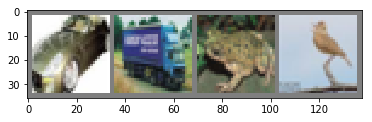

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    
    img = img / 2 + 0.5            # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
# get some random training images

dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images

imshow(torchvision.utils.make_grid(images))

# print labels

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

##### Define a Convolutional Neural Network

Copy the neural network from the Neural Network section before and modify it to take 3 - channel images (instead of 1 - channel images it was defined).

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self):
        
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

In [11]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


##### Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

##### Train the network

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [15]:
for epoch in range(2):             # loop over the dataset multiple times
    
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        
        # get the inputs
        
        inputs, labels = data
        
        # zero the parameter gradients
        
        optimizer.zero_grad()
        
        # forward + backward + optimize
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        
        running_loss += loss.item()
        
        if i % 2000 == 1999:       # print every 2000 mini-batches
            
            print('[%d, %5d] loss: %.3f' % 
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
print('Finished Training')

[1,  2000] loss: 2.236
[1,  4000] loss: 1.880
[1,  6000] loss: 1.706
[1,  8000] loss: 1.581
[1, 10000] loss: 1.549
[1, 12000] loss: 1.490
[2,  2000] loss: 1.434
[2,  4000] loss: 1.396
[2,  6000] loss: 1.388
[2,  8000] loss: 1.352
[2, 10000] loss: 1.335
[2, 12000] loss: 1.309
Finished Training


##### Test the network on the test data

We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We'll check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

Ground Truth:    cat  ship  ship plane


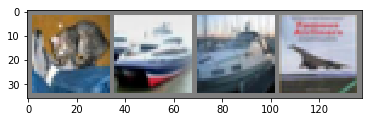

In [16]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))

print('Ground Truth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:

In [17]:
outputs = net(images)

The outputs are energies for the 10 classes. Higher the energy for a class, the more the network thinks that the image is of the particular class. So, let's get the index of the highest energy. 

In [18]:
_, predicted = torch.max(outputs, 1)

In [19]:
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship  ship  ship


The results seem pretty good.

Let us look at how the network performs on the whole dataset.

In [20]:
correct = 0
total = 0

with torch.no_grad():
    
    for data in testloader:
        
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). It seems like the network learnt something.

Let's see the classes that performed well, and the classes that did not perform well.

In [21]:
class_correct = list(0 for i in range(10))
class_total = list(0 for i in range(10))

with torch.no_grad():
    
    for data in testloader:
        
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        
        for i in range(4):
            
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 59 %
Accuracy of   car : 56 %
Accuracy of  bird : 36 %
Accuracy of   cat : 45 %
Accuracy of  deer : 27 %
Accuracy of   dog : 50 %
Accuracy of  frog : 64 %
Accuracy of horse : 44 %
Accuracy of  ship : 85 %
Accuracy of truck : 48 %


##### Training on GPU

Just like how you transfer a Tensor on to the GPU, you transfer the neural net onto the GPU.

Let's first define our device as the first visible cuda device if we have CUDA available:

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# assume that we're on a CUDA machine, then this should print a CUDA device:

print(device)

cpu


If on CUDA device, then these methods will recursively go over all modules and convert their parameters and buffers to CUDA tensors.

In [23]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Remember that you'll have to send the inputs and targets at every step to the GPU too:

In [24]:
inputs, labels = inputs.to(device), labels.to(device)

It is possible that we do not observe massive speedup compared to CPU as the network is smart.

##### Exercise:

Try increasing the width of your network (argument 2 of the first nn.Conv2d, and argument 1 of the second nn.Conv2d - they need to be the same number), see what kind of speedup you get.

##### Goals Achieved:

- Understanding PyTorch's Tensor library and neural networks at a high level
- Train a small neural network to classify images

##### Training on Multiple GPUs

If you want to see even more massive speedup using all your GPUs, please check out Optional: Data Parallelism (https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html).

##### Things to do next:

- Train neural nets to play video games (https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
- Train a state-of-the-art ResNet network on Imagenet (https://github.com/pytorch/examples/tree/master/imagenet)
- Train a face generator using Genertive Adversarial Networks (https://github.com/pytorch/examples/tree/master/dcgan)
- Train a word-level language model using Recurrent LSTM networks (https://github.com/pytorch/examples/tree/master/word_language_model)
- More examples (https://github.com/pytorch/examples)
- More tutorials (https://github.com/pytorch/tutorials)
- Discuss PyTorch on the Forums (https://discuss.pytorch.org/)
- Chat with other users on Slack (https://pytorch.slack.com/?redir=%2Fmessages%2Fbeginner%2F)